Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

In [3]:
X = digits.data
y = digits.target

In [4]:
X.shape, y.shape

((1797, 64), (1797,))

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [5]:
def draw_images(n, X):
    plt.gray()
    plt.subplot(3, 4, n)
    plt.imshow(16 - X[n-1].reshape(8,8))

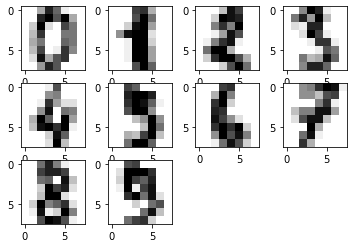

In [6]:
for i in list(range(1, 11)): 
    draw_images(i, X) 

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [7]:
from sklearn.cluster import KMeans,AgglomerativeClustering

In [8]:
images = load_digits().images

In [9]:
def draw_predicted_clusters(predictions):
    for element in enumerate(predictions[:12],1):
        plt.subplot(3,4, element[0])
        plt.axis("auto")
        plt.imshow(element[1][0].reshape(8,8))
        plt.title(f"Cluster №{element[1][1]}")
    plt.show()

In [10]:
ac = AgglomerativeClustering(n_clusters=10)
ac_pred = ac.fit_predict(X)

In [11]:
ac_pred

array([7, 9, 4, ..., 4, 1, 4], dtype=int64)

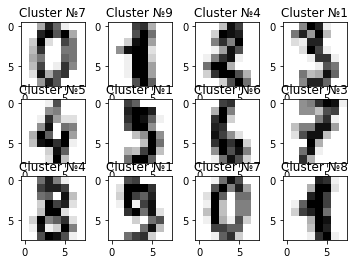

In [12]:
draw_predicted_clusters(list(zip((16-images), ac_pred)))

In [13]:
km = KMeans(n_clusters = 10, n_init = 100, random_state=42)
km_pred = km.fit_predict(X)

In [14]:
km_pred

array([1, 5, 5, ..., 5, 2, 2])

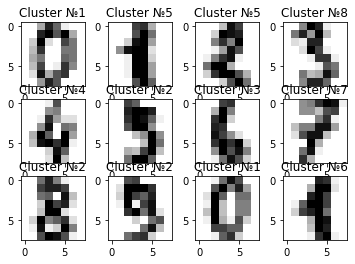

In [15]:
draw_predicted_clusters(list(zip((16-images), km_pred)))

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [16]:
def centers(position, data, predictions, cluster):
    a = []    
    for i in range(len(predictions)):
        if (predictions[i] == cluster):
            a.append(data[i])
    plt.gray()
    plt.subplot(3, 4, position)
    plt.imshow((16 - np.mean(a, axis=0)).reshape(8,8))
    #plt.title(f"Cluster №:{cluster}") 

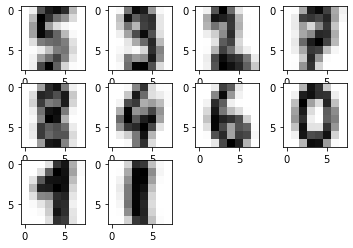

In [17]:
for i in list(range(1, 11)):
    centers(i, X , ac_pred, i-1)

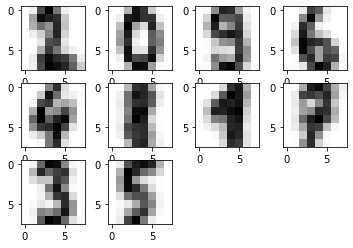

In [18]:
for i in list(range(1, 11)):
    centers(i, X, km_pred, i-1)

**Итого:** Сказать какой алгоритм лучше достаточно сложно. Если по качеству прорисовки, то, как мне кажется, K_Means выдал центры кластеров, больше похожие на типичные начертания цифр.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [19]:
from sklearn.metrics import silhouette_score

In [20]:
sil_ag = np.zeros(21)
for k in list(range(2, 21)):
    sil_ag[k] = silhouette_score(X, AgglomerativeClustering(n_clusters=k).fit_predict(X), metric='euclidean')   

In [21]:
sil_km = np.zeros(21)
for k in list(range(2, 21)):
    sil_km[k] = silhouette_score(X, KMeans(n_clusters = k, n_init = 200, random_state=42).fit_predict(X), metric='euclidean') 

In [22]:
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')

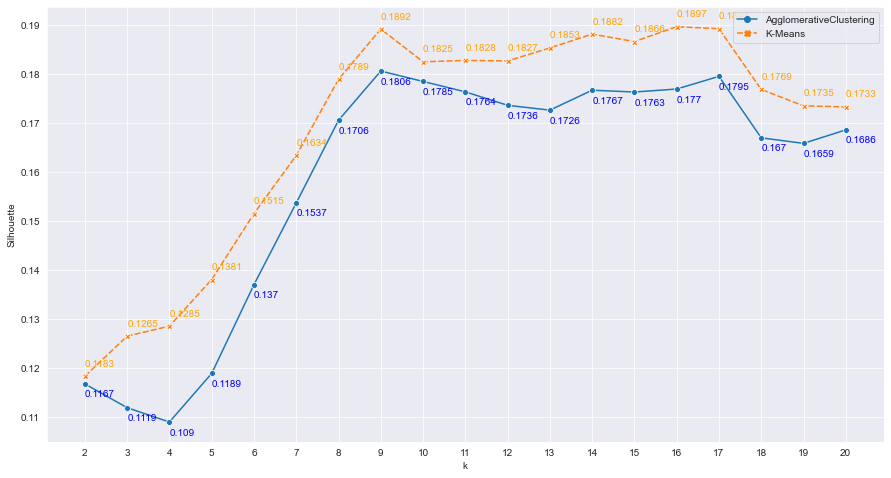

In [23]:
k = np.arange(19)
plt.figure(figsize=(15,8))
df=pd.DataFrame({'AgglomerativeClustering': sil_ag[2:],
                                'K-Means': sil_km[2:]}, index=k)
g = sns.lineplot(data=df, markers=True)
plt.xlabel('k')
plt.ylabel('Silhouette')
g.set_xticks(range(len(k)))
g.set_xticklabels(np.arange(2,21))

for x_x, y_y in zip(k, sil_ag[2:]):
    plt.text(x = x_x, 
             y = y_y-0.0027, 
             s = round(y_y, 4), 
             color = 'blue') 

for x_x, y_y in zip(k, sil_km[2:]):
    plt.text(x = x_x, 
             y = y_y+0.002, 
             s = round(y_y, 4), 
             color = 'orange') 

In [24]:
print(f'AgglomerativeClustering: max={round(np.max(sil_ag), 3)} при {np.argmax(sil_ag)} кластерах')
print(f'KMeans: max={round(np.max(sil_km), 3)} при {np.argmax(sil_km)} кластерах') 

AgglomerativeClustering: max=0.181 при 9 кластерах
KMeans: max=0.19 при 16 кластерах


**Итого:**  
Максимум силуэта у AgglomerativeClustering достигается при **9** кластерах.  
Максимум силуэта у KMeans достигается при **16** кластерах.

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [25]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score,homogeneity_completeness_v_measure

In [26]:
v_ag = np.zeros(21)
for k in list(range(2, 21)):
    v_ag[k] = v_measure_score(y, (AgglomerativeClustering(n_clusters=k).fit_predict(X)))

In [27]:
v_km = np.zeros(21)
for k in list(range(2, 21)):
    v_km[k] = v_measure_score(y, (KMeans(n_clusters=k, n_init = 200, random_state=42).fit_predict(X)))

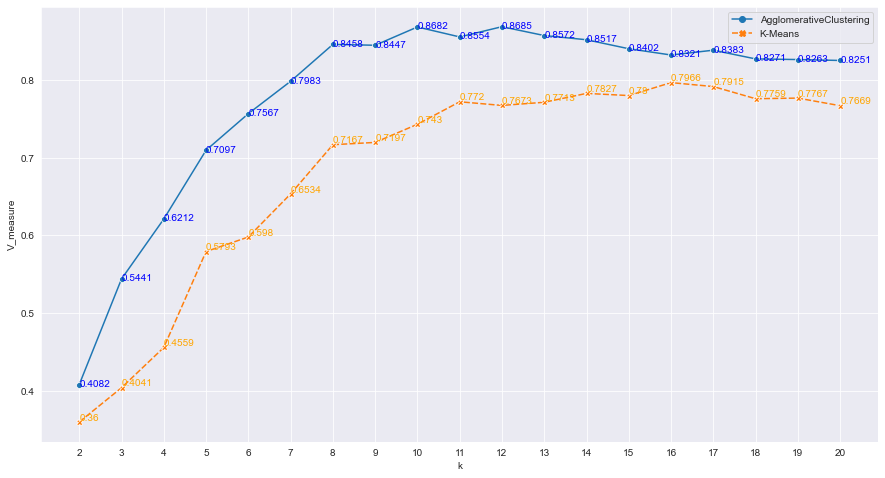

In [28]:
k = np.arange(19)
plt.figure(figsize=(15,8))
df=pd.DataFrame({'AgglomerativeClustering': v_ag[2:],
                                'K-Means': v_km[2:]}, index=k)
g = sns.lineplot(data=df, markers=True)
plt.xlabel('k')
plt.ylabel('V_measure')
g.set_xticks(range(len(k)))
g.set_xticklabels(np.arange(2,21))

for x_x, y_y in zip(k, v_ag[2:]):
    plt.text(x = x_x, 
             y = y_y-0.0027, 
             s = round(y_y, 4), 
             color = 'blue') 

for x_x, y_y in zip(k, v_km[2:]):
    plt.text(x = x_x, 
             y = y_y+0.002, 
             s = round(y_y, 4), 
             color = 'orange')

In [29]:
print(f'AgglomerativeClustering: max={round(np.max(v_ag), 4)} при {np.argmax(v_ag)} кластерах')
print(f'KMeans: max={round(np.max(v_km), 4)} при {np.argmax(v_km)} кластерах') 

AgglomerativeClustering: max=0.8685 при 12 кластерах
KMeans: max=0.7966 при 16 кластерах


**Итого:**  
Максимум 𝑉 -меры у AgglomerativeClustering достигается при **12** кластерах    
Максимум 𝑉 -меры у KMeans достигается при **16** кластерах    

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [30]:
from sklearn.decomposition import TruncatedSVD

In [31]:
def svd_calc(x,y,n_components=2):
    svd = TruncatedSVD(n_components, algorithm='randomized', n_iter=5)
    X_svd = svd.fit_transform(X)
    sil_ag = silhouette_score(X_svd, AgglomerativeClustering(n_clusters = 10).fit_predict(X_svd), metric='euclidean')
    sil_km = silhouette_score(X_svd, KMeans(n_clusters = 10, n_init = 200, random_state=42).fit_predict(X_svd), metric='euclidean')
    v_ag = v_measure_score(y, (AgglomerativeClustering(n_clusters = 10).fit_predict(X_svd)))
    v_km = v_measure_score(y, (KMeans(n_clusters = 10, n_init = 200, random_state=42).fit_predict(X_svd)))
    
    return sil_ag, sil_km, v_ag, v_km

In [32]:
initial_sil_ag = silhouette_score(X, AgglomerativeClustering(n_clusters = 10).fit_predict(X), metric='euclidean')
initial_sil_km = silhouette_score(X, KMeans(n_clusters = 10, n_init = 200, random_state=42).fit_predict(X), metric='euclidean')
initial_v_ag = v_measure_score(y, AgglomerativeClustering(n_clusters=10).fit_predict(X))
initial_v_km = v_measure_score(y, KMeans(n_clusters=10, n_init = 200, random_state=42).fit_predict(X))

In [33]:
components = [2, 5, 10, 20]
silhouette_AG = [initial_sil_ag, np.max(sil_ag)]
silhouette_KMeans = [initial_sil_km, np.max(sil_km)]
v_measure_AG = [initial_v_ag, np.max(v_ag)]
v_measure_KMeans = [initial_v_km, np.max(v_km)]
attempts = ['Initial', 'Max']

for n in components:
    sil_ag_temp, sil_km_temp, v_ag_temp, v_km_temp = svd_calc(X, y, n_components=n)
    silhouette_AG.append(sil_ag_temp)
    silhouette_KMeans.append(sil_km_temp)
    v_measure_AG.append(v_ag_temp)
    v_measure_KMeans.append(v_km_temp)
    attempts.append(f'n_components={n}')

In [34]:
df = pd.DataFrame({'silhouette_AgglomerativeClustering': silhouette_AG,
                   'silhouette_KMeans': silhouette_KMeans,
                   'v_measure_AgglomerativeClustering': v_measure_AG,
                   'v_measure_KMeans': v_measure_KMeans
                  }, index = attempts)
df

,silhouette_AgglomerativeClustering,silhouette_KMeans,v_measure_AgglomerativeClustering,v_measure_KMeans
Initial,0.178497,0.182504,0.868170,0.743025
Max,0.180620,0.189677,0.868549,0.796614
n_components=2,0.280817,0.348910,0.333719,0.348142
n_components=5,0.272742,0.312339,0.675604,0.633984
n_components=10,0.250712,0.263155,0.825975,0.720595
n_components=20,0.196971,0.212546,0.825257,0.741430


**Итого:**   
При всех значениях получилось получить silhouette больше, чем начальный и даже больше, чем максимальный из предыдущего задания.  
И для всех значений n_components не получилось улучшить v_measure.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [35]:
from sklearn.manifold import TSNE 

In [36]:
X_tsne = TSNE().fit_transform(X)

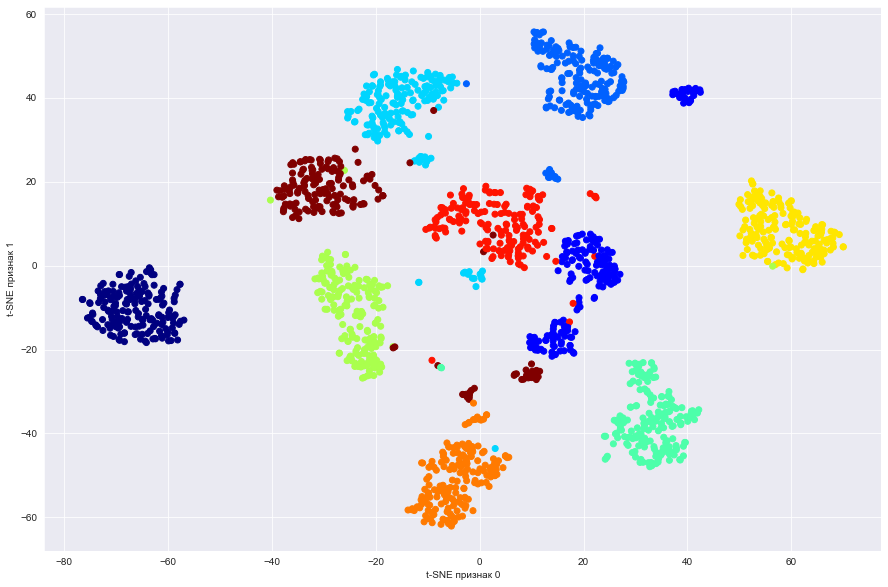

In [37]:
alpha = plt.figure(figsize=(15, 10))
plt.scatter((X_tsne.T[0]).T, (X_tsne.T[1]).T, c = y, alpha=1, cmap='jet')
plt.xlabel("t-SNE признак 0")
plt.ylabel("t-SNE признак 1")
plt.show()

Нарисуем что получилось немного в другом виде: отрисуем цифры в соответствующих кластерах

Text(0, 0.5, 't-SNE признак 1')

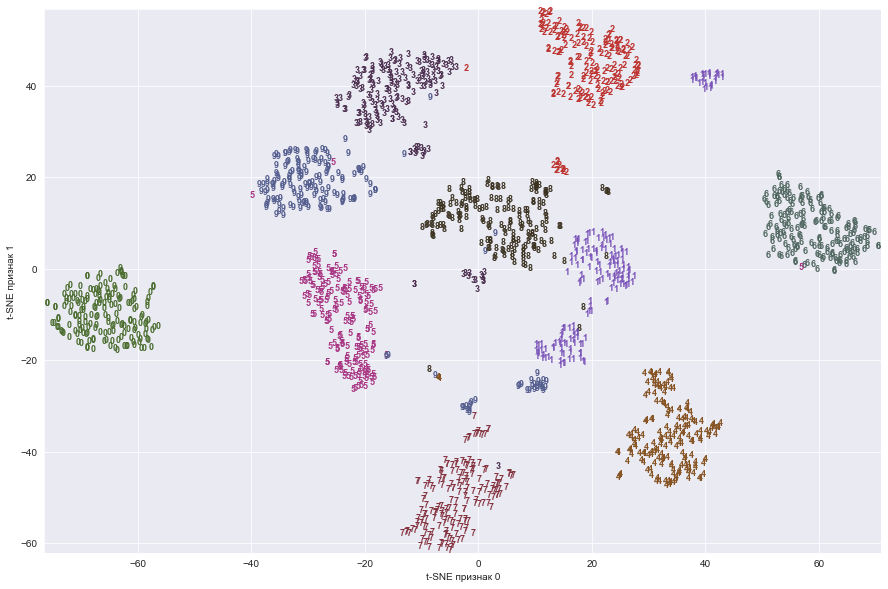

In [38]:
plt.figure(figsize=(15, 10))
plt.xlim(X_tsne[:, 0].min(), X_tsne[:, 0].max() + 1)
plt.ylim(X_tsne[:, 1].min(), X_tsne[:, 1].max() + 1)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
"#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
for i in range(len(X)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(X_tsne[i, 0], X_tsne[i, 1], str(y[i]),
    color = colors[int(y[i])],
    fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE признак 0")
plt.ylabel("t-SNE признак 1")

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [39]:
AG_tsne = AgglomerativeClustering(n_clusters = 10).fit_predict(X_tsne)
KM_tsne = KMeans(n_clusters = 10, n_init = 200, random_state=42).fit_predict(X_tsne)

In [40]:
sil_tsne_ag = silhouette_score(X_tsne, AG_tsne, metric='euclidean')
sil_tsne_km = silhouette_score(X_tsne, KM_tsne, metric='euclidean')
sil_tsne_ag, sil_tsne_km

(0.6286726, 0.6349182)

In [41]:
v_tsne_ag = v_measure_score(y, AG_tsne)
v_tsne_km = v_measure_score(y, KM_tsne)
v_tsne_ag, v_tsne_km

(0.8739170443073849, 0.899717628127654)

In [42]:
silhouette_AG = [initial_sil_ag, np.max(sil_ag), sil_tsne_ag]
silhouette_KMeans = [initial_sil_km, np.max(sil_km), sil_tsne_km]
v_measure_AG = [initial_v_ag, np.max(v_ag), v_tsne_ag]
v_measure_KMeans = [initial_v_km, np.max(v_km), v_tsne_km]
attempts = ['Initial', 'Max', 'TSNE']

In [43]:
df = pd.DataFrame({'silhouette_AgglomerativeClustering': silhouette_AG,
                   'silhouette_KMeans': silhouette_KMeans,
                   'v_measure_AgglomerativeClustering': v_measure_AG,
                   'v_measure_KMeans': v_measure_KMeans
                  }, index = attempts)
df

,silhouette_AgglomerativeClustering,silhouette_KMeans,v_measure_AgglomerativeClustering,v_measure_KMeans
Initial,0.178497,0.182504,0.868170,0.743025
Max,0.180620,0.189677,0.868549,0.796614
TSNE,0.628673,0.634918,0.873917,0.899718


**Итого:**   
Да, удалось получить и силуэт, и 𝑉 -меру лучше, чем на исходных данных

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

Выберем AgglomerativeClustering. Сначала отрисуем кластеры, какими цифрами они представлены, а потом отрисуем и центры кластеров

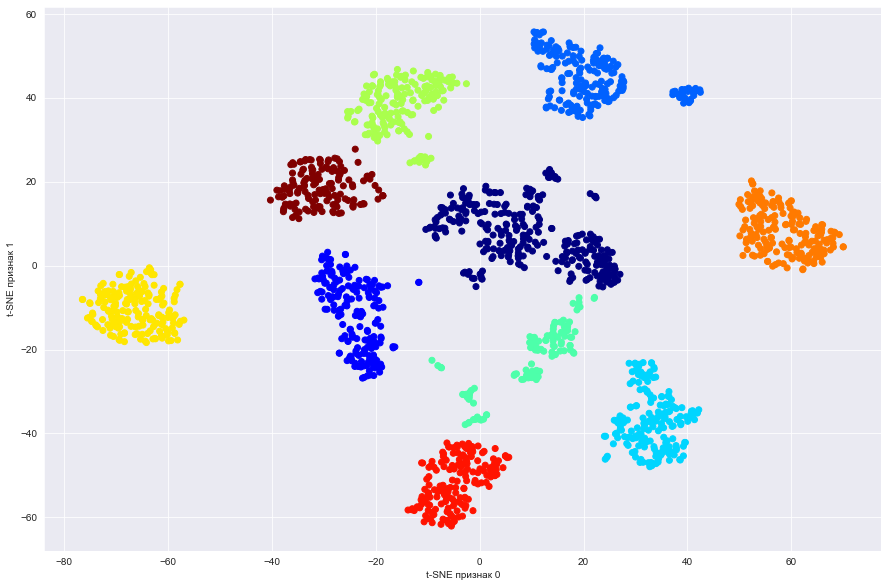

In [44]:
alpha = plt.figure(figsize=(15, 10))
plt.scatter((X_tsne.T[0]).T, (X_tsne.T[1]).T, c = AG_tsne, alpha=1, cmap='jet')
plt.xlabel("t-SNE признак 0")
plt.ylabel("t-SNE признак 1")
plt.show()

И теперь нарисуем все это цифрами

Text(0, 0.5, 't-SNE признак 1')

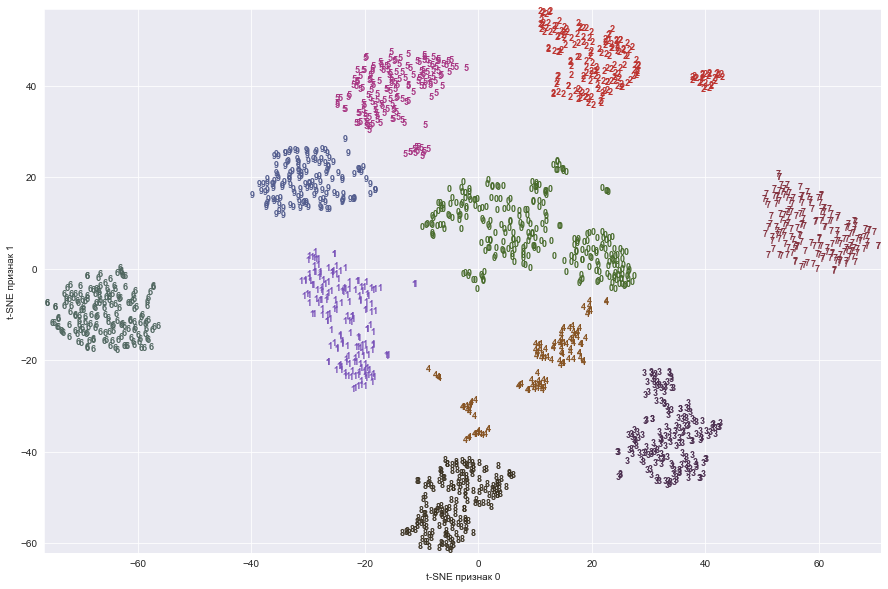

In [45]:
plt.figure(figsize=(15, 10))
plt.xlim(X_tsne[:, 0].min(), X_tsne[:, 0].max() + 1)
plt.ylim(X_tsne[:, 1].min(), X_tsne[:, 1].max() + 1)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
"#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
for i in range(len(X)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(X_tsne[i, 0], X_tsne[i, 1], str(AG_tsne[i]),
        color = colors[int(AG_tsne[i])],
        fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE признак 0")
plt.ylabel("t-SNE признак 1")

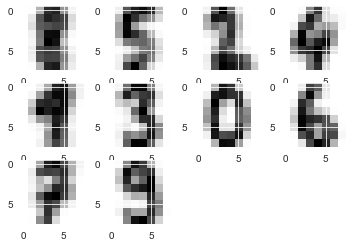

In [46]:
for i in list(range(1, 11)):
    centers(i, X, AG_tsne, i-1)

**Итого:**  
Я считаю, что получилось чтобы каждый кластер соответствовал какой-нибудь одной цифре. И центры кластеров теперь лучше прорисованы.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

Иерархическая кластеризация дает более осмысленные результы. В свою очередь качество алгоритма K-средних немного выше. Сингулярное разложение позволяет снизить размерность признакового пространства без существенной потери качества. Алгоритм TSNE позволяет значительно повысить качество кластеризации.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [47]:
from sklearn.datasets import fetch_openml

In [48]:
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [49]:
y_mnist

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [50]:
len(np.unique(y_mnist))

10

Т.е. у нас 10 цифр всего, значит идеальная разбивка должна быть на 10 кластеров

In [51]:
X_mnist.shape, y_mnist.shape

((70000, 784), (70000,))

Попробуем для начала посчитать силуэт и в-меру без изменения размерности

In [52]:
initial_KM = KMeans(n_clusters = 10, n_init = 200, random_state=42).fit_predict(X_mnist)

In [53]:
initial_sil_km = silhouette_score(X_mnist, initial_KM, metric='euclidean')

In [54]:
initial_v_km = v_measure_score(y_mnist, initial_KM)

Так как TSNE в предыдущих задачах показал наилучший результат, уменьшим размерность с помощью данного алгоритма.  
Но результат получить не удадось, так как TSNE требует много памяти и не хватило ресурсов для расчетов.  
Воспользуемся, в таком случае, UMAP.

In [55]:
import umap

Уменьшим размерность до 2.

In [56]:
X_mnist_umap = umap.UMAP(random_state=42).fit_transform(X_mnist)

Отрисуем что у нас получилось с кластерами после уменьшения размерности

Text(0, 0.5, 'umap признак 1')

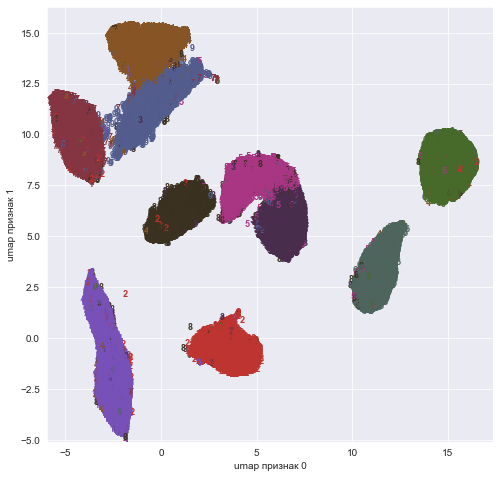

In [57]:
plt.figure(figsize=(8, 8))
plt.xlim(X_mnist_umap[:, 0].min(), X_mnist_umap[:, 0].max() + 1)
plt.ylim(X_mnist_umap[:, 1].min(), X_mnist_umap[:, 1].max() + 1)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
"#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
for i in range(len(X_mnist_umap)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(X_mnist_umap[i, 0], X_mnist_umap[i, 1], str(y_mnist[i]),
        color = colors[int(y_mnist[i])],
        fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("umap признак 0")
plt.ylabel("umap признак 1")

Используем K-means для кластеризации на данных после уменьшения размерности

In [58]:
KM_mnist_umap = KMeans(n_clusters = 10, n_init = 200, random_state=42).fit_predict(X_mnist_umap)

Рассчитаем силуэт и в-меру

In [59]:
umap_sil_km = silhouette_score(X_mnist_umap, KM_mnist_umap, metric='euclidean')

In [60]:
umap_v_km = v_measure_score(y_mnist, KM_mnist_umap)

Попробуем нормализовать исходные данные и проделаем шаги еще раз

In [61]:
from sklearn.preprocessing import MinMaxScaler

In [62]:
X_mnist_MMScaled = MinMaxScaler().fit_transform(X_mnist)

In [63]:
X_mnist_MMScaled_umap = umap.UMAP(random_state=42).fit_transform(X_mnist_MMScaled)

In [64]:
KM_mnist_MMScaled_umap = KMeans(n_clusters = 10, n_init = 200, random_state=42).fit_predict(X_mnist_MMScaled_umap)

In [65]:
umap_mm_sil_km = silhouette_score(X_mnist_MMScaled_umap, KM_mnist_MMScaled_umap, metric='euclidean')

In [66]:
umap_mm_v_km = v_measure_score(y_mnist, KM_mnist_MMScaled_umap)

А теперь попробуем кластеризовать с помощью dbscan (реализация взята не из sklern).  

In [67]:
import hdbscan

In [68]:
hdbscan_mnist_umap = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(X_mnist_umap)

In [69]:
umap_sil_hdb = silhouette_score(X_mnist_umap, hdbscan_mnist_umap, metric='euclidean')

In [70]:
umap_v_hdb = v_measure_score(y_mnist, hdbscan_mnist_umap)

Соберем теперь все расчеты в единый датафрейм

In [71]:
silhouette = [initial_sil_km, umap_sil_km, umap_mm_sil_km, umap_sil_hdb]
v_measure = [initial_v_km, umap_v_km, umap_mm_v_km, umap_v_hdb]
attempts = ['Initial', 'UMAP-KMEANS', 'MinMax-UMAP-KMeans', 'UMAP-DBSCAN']

In [72]:
df = pd.DataFrame({'silhouette': silhouette,
                   'v_measure': v_measure
                  }, index = attempts)
df

,silhouette,v_measure
Initial,0.058697,0.499725
UMAP-KMEANS,0.620067,0.857635
MinMax-UMAP-KMeans,0.618604,0.855021
UMAP-DBSCAN,0.604736,0.888449


**Итого:**  
Использование UMAP для снижения размерности позволило выполнить данную операцию достаточно быстро на таком большом датасете. T-SNE за все попытки не отработал ни разу и требует большого количества ресурсов. 
Также не хватило ресурсов на использование иерархической кластеризации. Поэтому использовался K-Means и Dbscan.
Как видно из таблицы результатов уменьшение размерности позволило существенно улучшить силуэт, а также v-measure. Нормализация данных ни к чему ни привела и использовать ее при кластеризации (по крайней мере в данном случае) нет смысла.   
Изменение алгоритма кластеризации с K-means на Dbscan позволило немного улучшить v-measure, при этом силуэт немного стал меньше.  
Для проекта я бы и взял последний набор алгоритмов - UMAP-DBSCAN